In [43]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

from utils.viz_helpers import plot_traj
from utils.metrics import get_ade, get_fde

device = 'cpu'

In [44]:
def denoise(gt_x, gt_y, w = 7):
    # denoising
    w = w
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.average(gt_x[iq: iq + w]))
            gt_y_t.append(np.average(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.average(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.average(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.average(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.average(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y


class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None, include_centerline = False):
        self.data = np.load(data_path)
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.include_centerline = include_centerline
        self.centerline_dir = centerline_dir
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        dt = self.dt
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
        
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
        
        gt_x = x_traj
        gt_y = y_traj
        
        ind = 1
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='blue', label='noisy')
        
        gt_x, gt_y = denoise(gt_x, gt_y)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='purple',label='before')
        
        # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)
        
        # obtain this -psi
        theta = -psi[self.t_obs - 1]
        
        # rotate by theta
        gt_x, gt_y = rotate(gt_x, gt_y, theta)
#         gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
#         gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
#         gt_x = gt_x_x
#         gt_y = gt_y_y
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='yellow') 
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
        psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
        psi_traj = [i.item() for i in psi]
        psidot_traj = [i.item() for i in psidot]
    
        
        x_traj = gt_x
        y_traj = gt_y

        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
#         psi_fut = psi_traj[self.t_obs:]
#         psidot_fut = psidot_traj[self.t_obs:]

        # till here, gt-> (32, 1), v -> (31, 1), psi -> (31, 1), psidot -> (30, 1)
        psi_fut = psi_traj[self.t_obs - 1:]
        psidot_fut = psi_traj[self.t_obs - 2:]
        
        vx_traj = v_x
        vy_traj = v_y
        
        vx_beg = vx_traj[self.t_obs]
        vy_beg = vy_traj[self.t_obs]
        
        vx_beg_prev = vx_traj[self.t_obs - 1]
        vy_beg_prev = vy_traj[self.t_obs - 1]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt

        vx_fin = v_x[-1]
        vy_fin = v_y[-1]
        
        vx_fin_prev = v_x[-2]
        vy_fin_prev = v_y[-2]

        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt

        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]

        traj_inp = np.vstack((x_inp, y_inp))
        traj_inp = np.swapaxes(traj_inp, 0, 1)
        if self.include_centerline:
            cs = np.load(self.centerline_dir)[idx]
            data = np.load(self.data_path)

            c_x = cs[:, 0]            
            c_y = cs[:, 1]
            c_x -= data[idx][0,0]
            c_y -= data[idx][0,1]
            c_x, c_y = denoise(c_x, c_y)
#             if idx == ind:
#                 plt.plot(c_x, c_y, color='black', label='grey')
            
            # rotate by theta
            c_x, c_y = rotate(c_x, c_y, theta)
            c_x -= c_x[0]
            c_y -= c_y[0]
            c_x += x_inp[-1]
            c_y += y_inp[-1]
        
#             c_y += y_inp[-1] + 2
            c_inp = np.dstack((c_x, c_y)).flatten()
            traj_inp = np.hstack((traj_inp, c_inp))

        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
        traj_out = np.vstack((x_fut, y_fut))#.flatten()
        traj_out = np.swapaxes(traj_out, 0, 1)
        
        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1]])

#             print(fixed_params)
#             print(var_inp)
#         return torch.tensor(traj_inp, dtype=torch.float32).flatten(), torch.tensor(traj_out, dtype=torch.float32).flatten(), torch.tensor(fixed_params), torch.tensor(var_inp)
        return torch.tensor(traj_inp, dtype=torch.float32), torch.tensor(traj_out, dtype=torch.float32), torch.tensor(fixed_params), torch.tensor(var_inp)

In [45]:
class TrajNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, embedding_size = 2, output_size=2, nvar=11, t_obs=8, num_layers = 1):
        super(TrajNet, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.linear1 = nn.Linear(input_size, embedding_size)
#         self.linear2 = nn.Linear(embedding_size, output_size)
        self.linear2 = nn.Linear(output_size, embedding_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.lstm2 = nn.LSTMCell(embedding_size, hidden_size)        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.activation = nn.ReLU()
        self.mask = torch.tensor([[0.0, 0.0, 1.0]], dtype=torch.double).to(device)
    
    def forward(self, x, fixed_params, var_inp):
        batch_size, _, _ = x.size()
        out = x
        encoder_hidden = (torch.zeros(batch_size, self.hidden_size, dtype=torch.float32), torch.zeros(batch_size, self.hidden_size, dtype=torch.float32))
#         hidden = self.lstm1(embedded, hidden)
        
        for i in range(20):
            encoder_input = x[:, i, :]
            embedded = self.activation(self.linear1(encoder_input))
            encoder_hidden = self.lstm1(embedded, encoder_hidden)
        
        decoder_input = encoder_input[:, :2]
        decoder_hidden = encoder_hidden
        
        decoder_outputs = torch.zeros(20, 30, 2)
        for i in range(30):
            embedded = self.activation(self.linear2(decoder_input))
            decoder_hidden = self.lstm2(embedded, decoder_hidden)
            decoder_output = self.linear3(decoder_hidden[0])
            decoder_input = decoder_output
            decoder_outputs[:, i, :] = decoder_output
        # Run optimization
        return decoder_outputs
#         out = self.activation(self.linear1(out))
#         out = self.activation(self.linear2(out))
#         return out

In [46]:
num = 30
t_obs = 20
num_elems = 15
include_centerline = False
name = "final_without" if include_centerline else "final_with"
lr = 0.001

train_dataset = ArgoverseDataset("/datasets/argoverse/val_data.npy", centerline_dir="/datasets/argoverse/val_centerlines.npy", t_obs=20, dt=0.3, include_centerline = include_centerline)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

test_dataset = ArgoverseDataset("/datasets/argoverse/val_test_data.npy", centerline_dir="/datasets/argoverse/val_test_centerlines.npy", t_obs=20, dt=0.3, include_centerline = include_centerline)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)

offsets_train = np.load("/datasets/argoverse/val_offsets.npy")
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

# model = TrajNet(input_size=t_obs * 2 + include_centerline * num_elems * 2, output_size= num * 2)
model = TrajNet()
model = model
model = model.to(device)
# model.lstm1.train()
# model.lstm2.train()
# model.load_state_dict(torch.load("./checkpoints/final.ckpt"))

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

torch.Size([20, 20, 2]) torch.Size([20, 30, 2])
torch.Size([20, 20, 2]) torch.Size([20, 30, 2]) torch.Size([20, 30, 2])


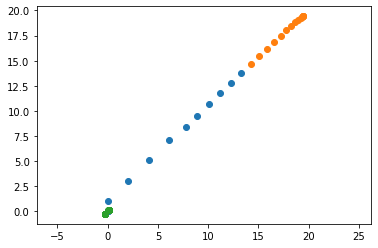

In [47]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
    torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
    ade = []
    fde = []
    print(traj_inp.shape, traj_out.shape)
    out = model(traj_inp, fixed_params, var_inp)
    plt.scatter(traj_inp[1][:40:2], traj_inp[1][1:40:2], label='inp')
    plt.scatter(traj_out[1][:60:2], traj_out[1][1:60:2], label='gt')
    plt.scatter(out[1][:60:2].detach(), out[1][1:60:2].detach(), label='pred')
    print(traj_inp.shape, traj_out.shape, out.shape)
#     plt.scatter(traj_inp[0, :, 0], traj_inp[0, :, 1], label='inp')
#     plt.scatter(traj_out[0, :, 0].detach(), traj_out[0, :, 1].detach(), label='gt')
# #     plt.scatter(traj_inp[1,:,0].detach(), traj_inp[1, :, 1].detach(), label='inp')
#     plt.scatter(out[0,:,0].detach(), out[0, :, 1].detach(), label='pred')
#     plt.legend()
    break

Epoch: 0, Batch: 0, Loss: 149.0938262939453
ADE: nan FDE: nan
Epoch: 0, Batch: 10, Loss: 162.99925231933594
ADE: nan FDE: nan
Epoch: 0, Batch: 20, Loss: 162.72589111328125
ADE: nan FDE: nan
Epoch: 0, Batch: 30, Loss: 86.40250396728516
ADE: nan FDE: nan
Epoch: 0, Batch: 40, Loss: 163.36776733398438
ADE: nan FDE: nan
Epoch: 0, Mean Loss: nan
Mean ADE: nan Mean FDE: nan
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 108.8814468383789
ADE: nan FDE: nan
Epoch: 1, Batch: 10, Loss: 113.47738647460938
ADE: nan FDE: nan
Epoch: 1, Batch: 20, Loss: 143.75767517089844
ADE: nan FDE: nan
Epoch: 1, Batch: 30, Loss: 76.092041015625
ADE: nan FDE: nan
Epoch: 1, Batch: 40, Loss: 161.10287475585938
ADE: nan FDE: nan
Epoch: 1, Mean Loss: nan
Mean ADE: nan Mean FDE: nan
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 108.92571258544922
ADE: nan FDE: n

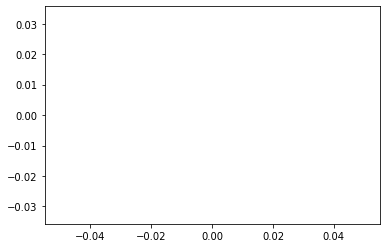

In [51]:
epoch_train_loss = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []    
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)

        ade = []
        fde = []
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         train_loss.append(loss.item())
#         for ii in range(traj_inp.size()[0]):
#             gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
#             print(out[ii][0])
#             pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
#             ade.append(get_ade(np.array(traj_out[ii].detach()), np.array(out[ii].detach())))
#             fde.append(get_fde(np.array(traj_out[ii].detach()), np.array(out[ii].detach())))
#             ade.append(get_ade(np.array(pred), np.array(gt)))
#             fde.append(get_fde(np.array(pred), np.array(gt)))
#             plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=t_obs * 2, c_len = t_obs * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))
    
        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))

    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    torch.save(model.state_dict(), "./checkpoints/{}.ckpt".format(name))
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

Batch: 0, Loss: 47.1984977722168
Batch: 1, Loss: 43.3056526184082
Batch: 2, Loss: 47.52375793457031
Batch: 3, Loss: 58.620155334472656
Batch: 4, Loss: 62.96497344970703
Batch: 5, Loss: 61.43911361694336
Batch: 6, Loss: 76.13151550292969
Batch: 7, Loss: 72.55301666259766
Batch: 8, Loss: 62.78532409667969
Batch: 9, Loss: 55.19141387939453
Epoch Mean Test Loss: 58.77134208679199
Mean ADE: nan Mean FDE: nan


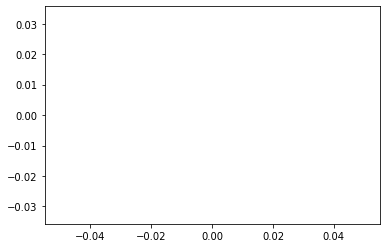

In [53]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    mean_ade = []
    mean_fde = []     
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)
        
        ade = []
        fde = []        
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
#         for ii in range(traj_inp.size()[0]):
#             gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
#             pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
#             ade.append(get_ade(np.array(pred), np.array(gt)))
#             fde.append(get_fde(np.array(pred), np.array(gt)))                        
#             plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traj(cnt, traj_inp, traj_out, traj_pred, obs, batch_num=0, num = 30, offsets = [], cities = [], avm = None, center = True, mode = "train", inp_len=40, c_len=70):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.detach().numpy()
    
    lane_centerlines = []
    ind = batch_num * 20 + cnt

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Get lane centerlines which lie within the range of trajectories
    ox = offsets[ind][0] + 2
    oy = offsets[ind][1] + 2
    ox = 0
    oy = 0
    if avm is not None:
        city = cities[ind]
        ox = offsets[ind][0] + 2
        oy = offsets[ind][1] + 2
        x_max = np.max(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        x_min = np.min(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        y_max = np.max(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        y_min = np.min(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        
        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline

            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            if True:
                ax.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

    ax.scatter(traj_inp[:inp_len:2] + ox, traj_inp[1:inp_len:2] + oy, color='blue', label='Inp traj')
    ax.scatter(traj_out[:num] + ox, traj_out[num:] + oy, color='orange', label='GT')
    ax.scatter(traj_pred[:num] + ox, traj_pred[num:] + oy, color='green', label='Pred')

    if center:
        ax.plot(traj_inp[inp_len:c_len:2] + ox , traj_inp[inp_len + 1:c_len:2] + oy, color='black',label='primary-centerline')
    
    ax.legend()
    ax.axis('equal')
    if mode == "train":
        plt.savefig('./results/{}.png'.format(cnt))
    else:
        plt.savefig('./results/{}.png'.format(batch_num * 20 + cnt))
    plt.close()
